# 24기 C반1조(이차전지) 설비 유의차 분석

#### IMPORT

In [6]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 로지스틱 회귀
from statsmodels.api import Logit
# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
import matplotlib.pyplot as plt
# 글꼴 적용
plt.rc('font', family = 'NanumBarunGothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

## 1. 데이터 구성하기 및 정제

In [8]:
df_raw = pd.read_csv("/home/piai/바탕화면/bat_process.csv")
df_raw.head()

,lot_id,tray_id,dt_start,cell_id,judge,rta1_cell_no,rta1_box_col,rta1_box_row,rta1_box_dan,hta1_box_col,...,ocv1_deltaocv,m1_thick,m1_voltage,m1_res_ac,m1_mv,m1_voltage_an,dt_start_old,sa4_box_row,sa4_box_col,sa4_box_dan
0,LOT-100,TRAY-1023,01SEP2022:10:01:25,CELL-10747,양품,10,08열,33연,08단,03열,...,6.8,4718.0,37583.0,94.0,565.0,164.0,01SEP2020:10:01:25,07열,27연,03단
1,LOT-100,TRAY-1023,01SEP2022:10:01:25,CELL-10748,양품,7,08열,33연,08단,03열,...,6.8,4718.0,37574.0,94.0,565.0,73.0,01SEP2020:10:01:25,07열,27연,03단
2,LOT-100,TRAY-1023,01SEP2022:10:01:25,CELL-10749,양품,19,08열,33연,08단,03열,...,6.9,4700.0,37579.0,91.0,585.0,-57.0,01SEP2020:10:01:25,07열,27연,03단
3,LOT-100,TRAY-1023,01SEP2022:10:01:25,CELL-10750,양품,24,08열,33연,08단,03열,...,6.9,4688.0,37583.0,93.0,606.0,99.0,01SEP2020:10:01:25,07열,27연,03단
4,LOT-100,TRAY-1023,01SEP2022:10:01:25,CELL-10751,양품,17,08열,33연,08단,03열,...,6.8,4696.0,37570.0,91.0,605.0,36.0,01SEP2020:10:01:25,07열,27연,03단


In [9]:
# Data 확인
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44078 entries, 0 to 44077
Columns: 113 entries, lot_id to sa4_box_dan
dtypes: float64(10), int64(54), object(49)
memory usage: 38.0+ MB


In [10]:
# Data 확인
print("Data 구조:", df_raw.shape)
print()
print("변수 : ", df_raw.columns)

Data 구조: (44078, 113)

변수 :  Index(['lot_id', 'tray_id', 'dt_start', 'cell_id', 'judge', 'rta1_cell_no',
       'rta1_box_col', 'rta1_box_row', 'rta1_box_dan', 'hta1_box_col',
       ...
       'ocv1_deltaocv', 'm1_thick', 'm1_voltage', 'm1_res_ac', 'm1_mv',
       'm1_voltage_an', 'dt_start_old', 'sa4_box_row', 'sa4_box_col',
       'sa4_box_dan'],
      dtype='object', length=113)


### 1-1. 필요한 열만 선택

In [11]:
# 설비 유의차에 필요한 열을 아래에 작성
columns_to_keep = ['tray_id', 'cell_id','judge','rta1_cell_no',
                   'rta1_box_col', 'rta1_box_dan',
                   'hta1_box_col', 'hta1_box_dan',
                   'rta2_box_col', 'rta2_box_dan',
                   'c1_box_col','c1_box_dan'
                    ] # 필요한 열을 모두 나열

# 선택한 열로 데이터프레임을 필터링
df_filtered = df_raw[columns_to_keep]


In [12]:
df_filtered.head()

,tray_id,cell_id,judge,rta1_cell_no,rta1_box_col,rta1_box_dan,hta1_box_col,hta1_box_dan,rta2_box_col,rta2_box_dan,c1_box_col,c1_box_dan
0,TRAY-1023,CELL-10747,양품,10,08열,08단,03열,03단,04열,06단,22열,08단
1,TRAY-1023,CELL-10748,양품,7,08열,08단,03열,03단,04열,06단,22열,08단
2,TRAY-1023,CELL-10749,양품,19,08열,08단,03열,03단,04열,06단,22열,08단
3,TRAY-1023,CELL-10750,양품,24,08열,08단,03열,03단,04열,06단,22열,08단
4,TRAY-1023,CELL-10751,양품,17,08열,08단,03열,03단,04열,06단,22열,08단


### 1-2. 결측치 제거

In [13]:
# 결측치 확인
missing_values = df_filtered.isnull().sum(axis = 1)

In [14]:
# 결측치가 특정 임계값보다 큰 행을 삭제
threshold = 1  # 예를 들어, 결측치가 1개 이상인 행을 삭제
rows_to_delete = missing_values[missing_values > threshold].index

# 97개 행 삭제
df_cleaned = df_filtered.drop(index=rows_to_delete)

In [15]:
# 97개 행 삭제 확인
df_cleaned

,tray_id,cell_id,judge,rta1_cell_no,rta1_box_col,rta1_box_dan,hta1_box_col,hta1_box_dan,rta2_box_col,rta2_box_dan,c1_box_col,c1_box_dan
0,TRAY-1023,CELL-10747,양품,10,08열,08단,03열,03단,04열,06단,22열,08단
1,TRAY-1023,CELL-10748,양품,7,08열,08단,03열,03단,04열,06단,22열,08단
2,TRAY-1023,CELL-10749,양품,19,08열,08단,03열,03단,04열,06단,22열,08단
3,TRAY-1023,CELL-10750,양품,24,08열,08단,03열,03단,04열,06단,22열,08단
4,TRAY-1023,CELL-10751,양품,17,08열,08단,03열,03단,04열,06단,22열,08단
...,...,...,...,...,...,...,...,...,...,...,...,...
44073,TRAY-2791,CELL-53649,양품,16,08열,03단,02열,06단,03열,06단,02열,05단
44074,TRAY-2791,CELL-53650,양품,14,08열,03단,02열,06단,03열,06단,02열,05단
44075,TRAY-2791,CELL-53651,양품,2,08열,03단,02열,06단,03열,06단,02열,05단
44076,TRAY-2791,CELL-54355,양품,15,08열,03단,02열,06단,03열,06단,02열,05단


### 1-3. judge 더미화

In [16]:
# 'judge' 열 더미화 (불량을 1로, 양품을 0으로)
df_raw = pd.get_dummies(df_cleaned, columns = ["judge"])

df_raw

,tray_id,cell_id,rta1_cell_no,rta1_box_col,rta1_box_dan,hta1_box_col,hta1_box_dan,rta2_box_col,rta2_box_dan,c1_box_col,c1_box_dan,judge_불량,judge_양품
0,TRAY-1023,CELL-10747,10,08열,08단,03열,03단,04열,06단,22열,08단,0,1
1,TRAY-1023,CELL-10748,7,08열,08단,03열,03단,04열,06단,22열,08단,0,1
2,TRAY-1023,CELL-10749,19,08열,08단,03열,03단,04열,06단,22열,08단,0,1
3,TRAY-1023,CELL-10750,24,08열,08단,03열,03단,04열,06단,22열,08단,0,1
4,TRAY-1023,CELL-10751,17,08열,08단,03열,03단,04열,06단,22열,08단,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44073,TRAY-2791,CELL-53649,16,08열,03단,02열,06단,03열,06단,02열,05단,0,1
44074,TRAY-2791,CELL-53650,14,08열,03단,02열,06단,03열,06단,02열,05단,0,1
44075,TRAY-2791,CELL-53651,2,08열,03단,02열,06단,03열,06단,02열,05단,0,1
44076,TRAY-2791,CELL-54355,15,08열,03단,02열,06단,03열,06단,02열,05단,0,1


In [17]:
# judge 열로 만들기 : 불량은 1이고, 양품은 0으로 변환됨
df_raw["judge"] = df_raw["judge_양품"] + df_raw["judge_불량"]*2 -1

df_raw

,tray_id,cell_id,rta1_cell_no,rta1_box_col,rta1_box_dan,hta1_box_col,hta1_box_dan,rta2_box_col,rta2_box_dan,c1_box_col,c1_box_dan,judge_불량,judge_양품,judge
0,TRAY-1023,CELL-10747,10,08열,08단,03열,03단,04열,06단,22열,08단,0,1,0
1,TRAY-1023,CELL-10748,7,08열,08단,03열,03단,04열,06단,22열,08단,0,1,0
2,TRAY-1023,CELL-10749,19,08열,08단,03열,03단,04열,06단,22열,08단,0,1,0
3,TRAY-1023,CELL-10750,24,08열,08단,03열,03단,04열,06단,22열,08단,0,1,0
4,TRAY-1023,CELL-10751,17,08열,08단,03열,03단,04열,06단,22열,08단,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44073,TRAY-2791,CELL-53649,16,08열,03단,02열,06단,03열,06단,02열,05단,0,1,0
44074,TRAY-2791,CELL-53650,14,08열,03단,02열,06단,03열,06단,02열,05단,0,1,0
44075,TRAY-2791,CELL-53651,2,08열,03단,02열,06단,03열,06단,02열,05단,0,1,0
44076,TRAY-2791,CELL-54355,15,08열,03단,02열,06단,03열,06단,02열,05단,0,1,0


In [18]:
df_raw["judge"] = df_raw["judge"].astype("int64")

In [19]:
# 필요없는 변수 제거
df_raw = df_raw.drop(["judge_양품","judge_불량"], axis=1)

df_raw

,tray_id,cell_id,rta1_cell_no,rta1_box_col,rta1_box_dan,hta1_box_col,hta1_box_dan,rta2_box_col,rta2_box_dan,c1_box_col,c1_box_dan,judge
0,TRAY-1023,CELL-10747,10,08열,08단,03열,03단,04열,06단,22열,08단,0
1,TRAY-1023,CELL-10748,7,08열,08단,03열,03단,04열,06단,22열,08단,0
2,TRAY-1023,CELL-10749,19,08열,08단,03열,03단,04열,06단,22열,08단,0
3,TRAY-1023,CELL-10750,24,08열,08단,03열,03단,04열,06단,22열,08단,0
4,TRAY-1023,CELL-10751,17,08열,08단,03열,03단,04열,06단,22열,08단,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44073,TRAY-2791,CELL-53649,16,08열,03단,02열,06단,03열,06단,02열,05단,0
44074,TRAY-2791,CELL-53650,14,08열,03단,02열,06단,03열,06단,02열,05단,0
44075,TRAY-2791,CELL-53651,2,08열,03단,02열,06단,03열,06단,02열,05단,0
44076,TRAY-2791,CELL-54355,15,08열,03단,02열,06단,03열,06단,02열,05단,0


## 2. tray별 불량율 계산

### 2-1. tray별 불량 개수

In [20]:
# df_raw에서 tray_id와 judge 열만 선택합니다.
subset_df = df_raw[['tray_id', 'judge']]

# tray_id로 그룹화하고 각 그룹 내의 judge 값을 합산합니다.
result_df = subset_df.groupby('tray_id')['judge'].sum().reset_index()

# 결과를 출력합니다.
print(result_df)

        tray_id  judge
0     TRAY-1002      0
1     TRAY-1003      0
2     TRAY-1004      0
3     TRAY-1005      0
4     TRAY-1006      0
...         ...    ...
1784  TRAY-2787      4
1785  TRAY-2788      6
1786  TRAY-2789      3
1787  TRAY-2790      1
1788  TRAY-2791      5

[1789 rows x 2 columns]


### 2-2. tray의 cell 개수 세기

In [21]:
import pandas as pd

# 데이터프레임에서 tray_id 열 중에서 같은 값을 가진 행의 개수를 구합니다.
tray_id_counts = df_raw['tray_id'].value_counts().reset_index()
tray_id_counts.columns = ['tray_id', 'count']

# 결과를 출력합니다.
print(tray_id_counts)

        tray_id  count
0     TRAY-1901     25
1     TRAY-2213     25
2     TRAY-2171     25
3     TRAY-2165     25
4     TRAY-2164     25
...         ...    ...
1784  TRAY-1518      4
1785  TRAY-2776      2
1786  TRAY-2778      1
1787  TRAY-2767      1
1788  TRAY-2769      1

[1789 rows x 2 columns]


### 2-3. tray별 불량률 계산

In [22]:
import pandas as pd

# 데이터프레임에서 tray_id 열 중에서 같은 값을 가진 행의 개수를 구합니다.
tray_id_counts = df_raw['tray_id'].value_counts().reset_index()
tray_id_counts.columns = ['tray_id', 'count']

# tray_id 별로 judge 값을 합산한 결과 데이터프레임
subset_df = df_raw[['tray_id', 'judge']]
result_df = subset_df.groupby('tray_id')['judge'].sum().reset_index()
result_df.columns = ['tray_id', 'judge_sum']

# tray_id_counts와 result_df를 병합하여 비율을 계산합니다.
merged_df = tray_id_counts.merge(result_df, on='tray_id', how='left')

# count와 judge_sum을 사용하여 비율을 계산합니다.
merged_df['ratio'] = merged_df['judge_sum'] / merged_df['count'] * 100

# 결과를 출력합니다.
print(merged_df)


        tray_id  count  judge_sum  ratio
0     TRAY-1901     25          0    0.0
1     TRAY-2213     25          1    4.0
2     TRAY-2171     25         12   48.0
3     TRAY-2165     25          0    0.0
4     TRAY-2164     25          0    0.0
...         ...    ...        ...    ...
1784  TRAY-1518      4          0    0.0
1785  TRAY-2776      2          0    0.0
1786  TRAY-2778      1          0    0.0
1787  TRAY-2767      1          0    0.0
1788  TRAY-2769      1          0    0.0

[1789 rows x 4 columns]


In [23]:
# df_raw 데이터프레임에 merged_df의 'tray_id'와 'ratio' 열을 병합합니다.
df_raw = df_raw.merge(merged_df[['tray_id', 'ratio']], on='tray_id', how='left')

# 결과를 출력합니다.
print(df_raw)

         tray_id     cell_id  rta1_cell_no rta1_box_col rta1_box_dan  \
0      TRAY-1023  CELL-10747            10          08열          08단   
1      TRAY-1023  CELL-10748             7          08열          08단   
2      TRAY-1023  CELL-10749            19          08열          08단   
3      TRAY-1023  CELL-10750            24          08열          08단   
4      TRAY-1023  CELL-10751            17          08열          08단   
...          ...         ...           ...          ...          ...   
44073  TRAY-2791  CELL-53649            16          08열          03단   
44074  TRAY-2791  CELL-53650            14          08열          03단   
44075  TRAY-2791  CELL-53651             2          08열          03단   
44076  TRAY-2791  CELL-54355            15          08열          03단   
44077  TRAY-2791  CELL-54356            10          08열          03단   

      hta1_box_col hta1_box_dan rta2_box_col rta2_box_dan c1_box_col  \
0              03열          03단          04열          06단      

## 3. 설비 별 불량 판정 분석 (카이제곱 검정)

### 3-1. 'rta1_box_col'(상온 Aging1 열)에서의 불량판정

In [25]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['rta1_box_col', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      rta1_box_col  judge
0              08열      0
1              08열      0
2              08열      0
3              08열      0
4              08열      0
...            ...    ...
44073          08열      0
44074          08열      0
44075          08열      0
44076          08열      0
44077          08열      1

[44078 rows x 2 columns]


In [26]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['rta1_box_col'] = data_copy['rta1_box_col'].str.replace('열', '')

# 결과 확인
print(data_copy)

      rta1_box_col  judge
0               08      0
1               08      0
2               08      0
3               08      0
4               08      0
...            ...    ...
44073           08      0
44074           08      0
44075           08      0
44076           08      0
44077           08      1

[44078 rows x 2 columns]


In [27]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['rta1_box_col'] = data_copy['rta1_box_col'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['rta1_box_col'] = pd.Categorical(data_copy['rta1_box_col'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['rta1_box_col'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 10.909534616807763
p-값 (p-value): 0.14261404571899725


### 3-2. 'rta1_box_dan'(상온 Aging1 단)에서의 불량판정

In [28]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['rta1_box_dan', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      rta1_box_dan  judge
0              08단      0
1              08단      0
2              08단      0
3              08단      0
4              08단      0
...            ...    ...
44073          03단      0
44074          03단      0
44075          03단      0
44076          03단      0
44077          03단      1

[44078 rows x 2 columns]


In [29]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['rta1_box_dan'] = data_copy['rta1_box_dan'].str.replace('열', '')

# 결과 확인
print(data_copy)

      rta1_box_dan  judge
0              08단      0
1              08단      0
2              08단      0
3              08단      0
4              08단      0
...            ...    ...
44073          03단      0
44074          03단      0
44075          03단      0
44076          03단      0
44077          03단      1

[44078 rows x 2 columns]


In [30]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['rta1_box_dan'] = data_copy['rta1_box_dan'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['rta1_box_dan'] = pd.Categorical(data_copy['rta1_box_dan'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['rta1_box_dan'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 65.94173537648307
p-값 (p-value): 2.676040212281309e-10


### 3-3. 'hta1_box_col'(고온 Aging1 열)에서의 불량판정

In [31]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['hta1_box_col', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      hta1_box_col  judge
0              03열      0
1              03열      0
2              03열      0
3              03열      0
4              03열      0
...            ...    ...
44073          02열      0
44074          02열      0
44075          02열      0
44076          02열      0
44077          02열      1

[44078 rows x 2 columns]


In [32]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['hta1_box_col'] = data_copy['hta1_box_col'].str.replace('열', '')

# 결과 확인
print(data_copy)

      hta1_box_col  judge
0               03      0
1               03      0
2               03      0
3               03      0
4               03      0
...            ...    ...
44073           02      0
44074           02      0
44075           02      0
44076           02      0
44077           02      1

[44078 rows x 2 columns]


In [33]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['hta1_box_col'] = data_copy['hta1_box_col'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['hta1_box_col'] = pd.Categorical(data_copy['hta1_box_col'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['hta1_box_col'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 7.685211377503119
p-값 (p-value): 0.02143766861312657


### 3-4. 'hta1_box_dan'(고온 Aging1 단)에서의 불량판정

In [34]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['hta1_box_dan', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      hta1_box_dan  judge
0              03단      0
1              03단      0
2              03단      0
3              03단      0
4              03단      0
...            ...    ...
44073          06단      0
44074          06단      0
44075          06단      0
44076          06단      0
44077          06단      1

[44078 rows x 2 columns]


In [35]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['hta1_box_dan'] = data_copy['hta1_box_dan'].str.replace('열', '')

# 결과 확인
print(data_copy)

      hta1_box_dan  judge
0              03단      0
1              03단      0
2              03단      0
3              03단      0
4              03단      0
...            ...    ...
44073          06단      0
44074          06단      0
44075          06단      0
44076          06단      0
44077          06단      1

[44078 rows x 2 columns]


In [36]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['hta1_box_dan'] = data_copy['hta1_box_dan'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['hta1_box_dan'] = pd.Categorical(data_copy['hta1_box_dan'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['hta1_box_dan'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 87.23667015921384
p-값 (p-value): 5.8267347522904985e-15


### 3-5. 'rta2_box_col'(상온 Aging2 열)에서의 불량판정

In [37]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['rta2_box_col', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      rta2_box_col  judge
0              04열      0
1              04열      0
2              04열      0
3              04열      0
4              04열      0
...            ...    ...
44073          03열      0
44074          03열      0
44075          03열      0
44076          03열      0
44077          03열      1

[44078 rows x 2 columns]


In [38]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['rta2_box_col'] = data_copy['rta2_box_col'].str.replace('열', '')

# 결과 확인
print(data_copy)

      rta2_box_col  judge
0               04      0
1               04      0
2               04      0
3               04      0
4               04      0
...            ...    ...
44073           03      0
44074           03      0
44075           03      0
44076           03      0
44077           03      1

[44078 rows x 2 columns]


In [39]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['rta2_box_col'] = data_copy['rta2_box_col'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['rta2_box_col'] = pd.Categorical(data_copy['rta2_box_col'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['rta2_box_col'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 44.92979032627834
p-값 (p-value): 1.411195604656491e-07


### 3-6. 'rta2_box_dan'(상온 Aging2 단)에서의 불량판정

In [40]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['rta2_box_dan', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      rta2_box_dan  judge
0              06단      0
1              06단      0
2              06단      0
3              06단      0
4              06단      0
...            ...    ...
44073          06단      0
44074          06단      0
44075          06단      0
44076          06단      0
44077          06단      1

[44078 rows x 2 columns]


In [41]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['rta2_box_dan'] = data_copy['rta2_box_dan'].str.replace('열', '')

# 결과 확인
print(data_copy)

      rta2_box_dan  judge
0              06단      0
1              06단      0
2              06단      0
3              06단      0
4              06단      0
...            ...    ...
44073          06단      0
44074          06단      0
44075          06단      0
44076          06단      0
44077          06단      1

[44078 rows x 2 columns]


In [42]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['rta2_box_dan'] = data_copy['rta2_box_dan'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['rta2_box_dan'] = pd.Categorical(data_copy['rta2_box_dan'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['rta2_box_dan'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 73.6959697934462
p-값 (p-value): 8.530299449082667e-12


### 3-7. 'c1_box_col'(충전 1단계 열)에서의 불량판정

In [43]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['c1_box_col', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      c1_box_col  judge
0            22열      0
1            22열      0
2            22열      0
3            22열      0
4            22열      0
...          ...    ...
44073        02열      0
44074        02열      0
44075        02열      0
44076        02열      0
44077        02열      1

[44078 rows x 2 columns]


In [44]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['c1_box_col'] = data_copy['c1_box_col'].str.replace('열', '')

# 결과 확인
print(data_copy)

      c1_box_col  judge
0             22      0
1             22      0
2             22      0
3             22      0
4             22      0
...          ...    ...
44073         02      0
44074         02      0
44075         02      0
44076         02      0
44077         02      1

[44078 rows x 2 columns]


In [45]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['c1_box_col'] = data_copy['c1_box_col'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['c1_box_col'] = pd.Categorical(data_copy['c1_box_col'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['c1_box_col'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 760.259670210774
p-값 (p-value): 2.3861014544564714e-147


### 3-8. 'c1_box_dan'(충전 1단계 단)에서의 불량판정

In [46]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['c1_box_dan', 'judge']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      c1_box_dan  judge
0            08단      0
1            08단      0
2            08단      0
3            08단      0
4            08단      0
...          ...    ...
44073        05단      0
44074        05단      0
44075        05단      0
44076        05단      0
44077        05단      1

[44078 rows x 2 columns]


In [47]:
# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리
data_copy['c1_box_dan'] = data_copy['c1_box_dan'].str.replace('열', '')

# 결과 확인
print(data_copy)

      c1_box_dan  judge
0            08단      0
1            08단      0
2            08단      0
3            08단      0
4            08단      0
...          ...    ...
44073        05단      0
44074        05단      0
44075        05단      0
44076        05단      0
44077        05단      1

[44078 rows x 2 columns]


In [48]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임 복사본 생성
data_copy = df.copy()

# '열'을 삭제하고 정리 (rta1_box_col 열만 고려)
data_copy['c1_box_dan'] = data_copy['c1_box_dan'].str.replace('열', '')

# 'rta1_box_col'와 'judge' 열을 범주형 변수로 변환
data_copy['c1_box_dan'] = pd.Categorical(data_copy['c1_box_dan'])
data_copy['judge'] = pd.Categorical(data_copy['judge'])

# 교차표(crosstab) 생성
cross_tab = pd.crosstab(data_copy['c1_box_dan'], data_copy['judge'])

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency(cross_tab)

# 결과 출력
print("카이제곱 통계량 (Chi-Square):", chi2)
print("p-값 (p-value):", p)

카이제곱 통계량 (Chi-Square): 243.34840132332047
p-값 (p-value): 1.3568841981247403e-46


# 4. 설비 별 불량률 차이 분석(ANOVA)

### 4-1. 'rta1_box_col', 'rta1_box_dan'(상온 Aging 1의 열과 단)에서의 불량률 판정

In [49]:
import pandas as pd
import scipy.stats as stats

# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['rta1_box_col', 'rta1_box_dan', 'ratio']
data = df_raw[columns_to_keep]

# 결과 출력
print(data)

      rta1_box_col rta1_box_dan  ratio
0              08열          08단    0.0
1              08열          08단    0.0
2              08열          08단    0.0
3              08열          08단    0.0
4              08열          08단    0.0
...            ...          ...    ...
44073          08열          03단   20.0
44074          08열          03단   20.0
44075          08열          03단   20.0
44076          08열          03단   20.0
44077          08열          03단   20.0

[44078 rows x 3 columns]


In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA 모델 설정
formula = 'ratio ~ C(rta1_box_col) + C(rta1_box_dan)'
model = ols(formula, data=data).fit()

# ANOVA 분석 실행
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                       sum_sq       df          F        PR(>F)
C(rta1_box_col)  3.927333e+03      7.0   6.704715  5.810450e-08
C(rta1_box_dan)  2.057065e+04     10.0  24.582642  5.633729e-47
Residual         3.686921e+06  44060.0        NaN           NaN


### 4-2. 'hta1_box_col', 'hta1_box_dan'(고온 Aging 2 열과 단)에서의 불량률 판정

In [51]:
import pandas as pd
import scipy.stats as stats

# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['hta1_box_col', 'hta1_box_dan', 'ratio']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      hta1_box_col hta1_box_dan  ratio
0              03열          03단    0.0
1              03열          03단    0.0
2              03열          03단    0.0
3              03열          03단    0.0
4              03열          03단    0.0
...            ...          ...    ...
44073          02열          06단   20.0
44074          02열          06단   20.0
44075          02열          06단   20.0
44076          02열          06단   20.0
44077          02열          06단   20.0

[44078 rows x 3 columns]


In [52]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA 모델 설정
formula = 'ratio ~ C(hta1_box_col) + C(hta1_box_dan)'
model = ols(formula, data=df).fit()

# ANOVA 분석 실행
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                       sum_sq       df          F        PR(>F)
C(hta1_box_col)  2.572333e+03      2.0  15.393465  2.075091e-07
C(hta1_box_dan)  2.663097e+04      9.0  35.414709  4.772801e-63
Residual         3.681836e+06  44066.0        NaN           NaN


### 4-3. 'rta2_box_col', 'rta2_box_dan'(상온 Aging 2의 열과 단)에서의 불량률 판정

In [53]:
import pandas as pd
import scipy.stats as stats

# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['rta2_box_col', 'rta2_box_dan', 'ratio']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      rta2_box_col rta2_box_dan  ratio
0              04열          06단    0.0
1              04열          06단    0.0
2              04열          06단    0.0
3              04열          06단    0.0
4              04열          06단    0.0
...            ...          ...    ...
44073          03열          06단   20.0
44074          03열          06단   20.0
44075          03열          06단   20.0
44076          03열          06단   20.0
44077          03열          06단   20.0

[44078 rows x 3 columns]


In [54]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA 모델 설정
formula = 'ratio ~ C(rta2_box_col) + C(rta2_box_dan)'
model = ols(formula, data=df).fit()

# ANOVA 분석 실행
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                       sum_sq       df          F        PR(>F)
C(rta2_box_col)  1.354949e+04      7.0  23.206923  1.126600e-31
C(rta2_box_dan)  2.224921e+04     10.0  26.675167  2.361470e-51
Residual         3.674954e+06  44060.0        NaN           NaN


### 4-4. 'c1_box_col','c1_box_dan'(충전 1단계에서의 열과 단)에서의 불량률 판정

In [55]:
import pandas as pd
import scipy.stats as stats

# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['c1_box_col','c1_box_dan', 'ratio']
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

      c1_box_col c1_box_dan  ratio
0            22열        08단    0.0
1            22열        08단    0.0
2            22열        08단    0.0
3            22열        08단    0.0
4            22열        08단    0.0
...          ...        ...    ...
44073        02열        05단   20.0
44074        02열        05단   20.0
44075        02열        05단   20.0
44076        02열        05단   20.0
44077        02열        05단   20.0

[44078 rows x 3 columns]


In [56]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA 모델 설정
formula = 'ratio ~ C(c1_box_col) + C(c1_box_dan)'
model = ols(formula, data=df).fit()

# ANOVA 분석 실행
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq       df           F         PR(>F)
C(c1_box_col)  2.300810e+05     21.0  141.638450   0.000000e+00
C(c1_box_dan)  7.375223e+04     10.0   95.344329  2.957444e-196
Residual       3.407115e+06  44046.0         NaN            NaN


# 5. 설비 유의차와 불량률간의 관계 시각화(Heat Map)
### 시각화 후보
1) 'rta1_box_col', 'rta1_box_dan',
2) 'hta1_box_col', 'hta1_box_dan',
3) 'rta2_box_col', 'rta2_box_dan',
4) 'ocv1_box_col','ocv1_box_dan','c1_box_col','c1_box_dan','dc1_box_col','dc1_box_dan','c2_box_col','c2_box_dan','dc2_box_col','dc2_box_dan','c3_box_col','c3_box_dan','dc3_box_col','dc3_box_dan','c4_box_col','c4_box_dan','ocv2_box_col','ocv2_box_dan'

### 5-1. rta1_box_col, rta1_box_dan(상온 Aging 1 열과 단)에서의 불량률

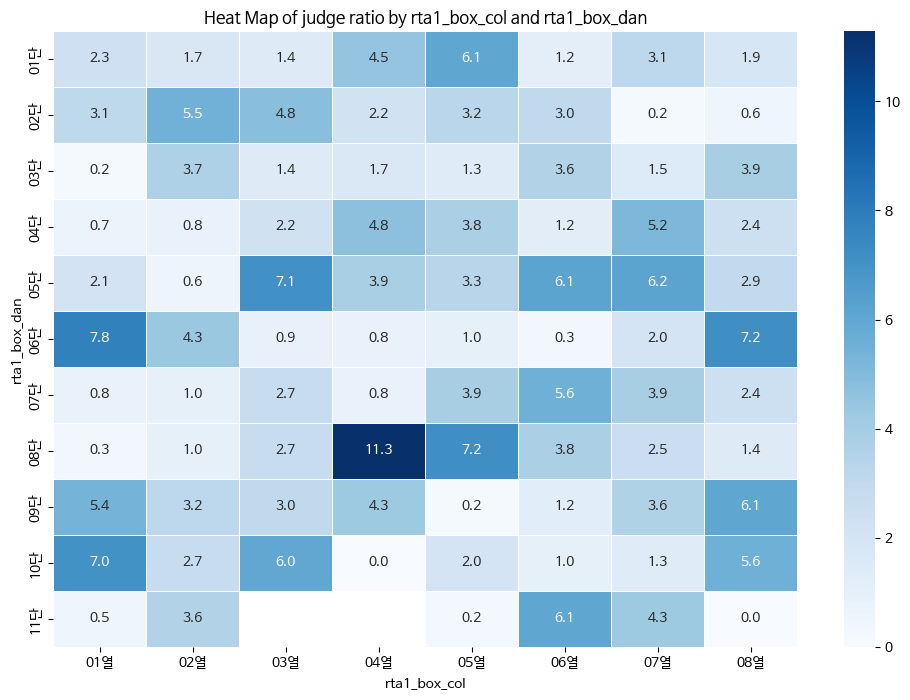

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_raw['c1_box_col'] = df_raw['c1_box_col'].astype('category')
df_raw['c1_box_dan'] = df_raw['c1_box_dan'].astype('category')

# 'rta1_box_col'과 'rta1_box_dan'을 기준으로 그룹화하고, 'judge ratio'의 평균을 계산합니다.
heatmap_data = df_raw.groupby(['rta1_box_col', 'rta1_box_dan'])['ratio'].mean().reset_index()

# 피벗 테이블을 생성하여 데이터를 히트맵에 맞는 형태로 변환합니다.
heatmap_data_pivot = heatmap_data.pivot(index='rta1_box_dan', columns='rta1_box_col', values='ratio')

# 히트맵을 그립니다.
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt=".1f", linewidths=0.5)
plt.title('Heat Map of judge ratio by rta1_box_col and rta1_box_dan')
plt.show()


In [58]:
# judge ratio'의 평균을 계산합니다.
heatmap_data = df_raw.groupby(['rta1_box_col', 'rta1_box_dan'])['ratio'].mean().reset_index()

# 'judge ratio' 열을 기준으로 내림차순 정렬하여 가장 큰 10개의 값을 선택합니다.
top_10_values_1 = heatmap_data.sort_values(by='ratio', ascending=False).head(10)

# 결과를 출력합니다.
print(top_10_values_1)

   rta1_box_col rta1_box_dan      ratio
39          04열          08단  11.296296
5           01열          06단   7.803468
49          05열          08단   7.173601
80          08열          06단   7.163324
26          03열          05단   7.098121
9           01열          10단   7.042254
68          07열          05단   6.170886
57          06열          05단   6.138934
63          06열          11단   6.084656
83          08열          09단   6.068268


### 5-2. 'hta1_box_col', 'hta1_box_dan'(고온 Aging 2의 열과 단)에서의 불량률

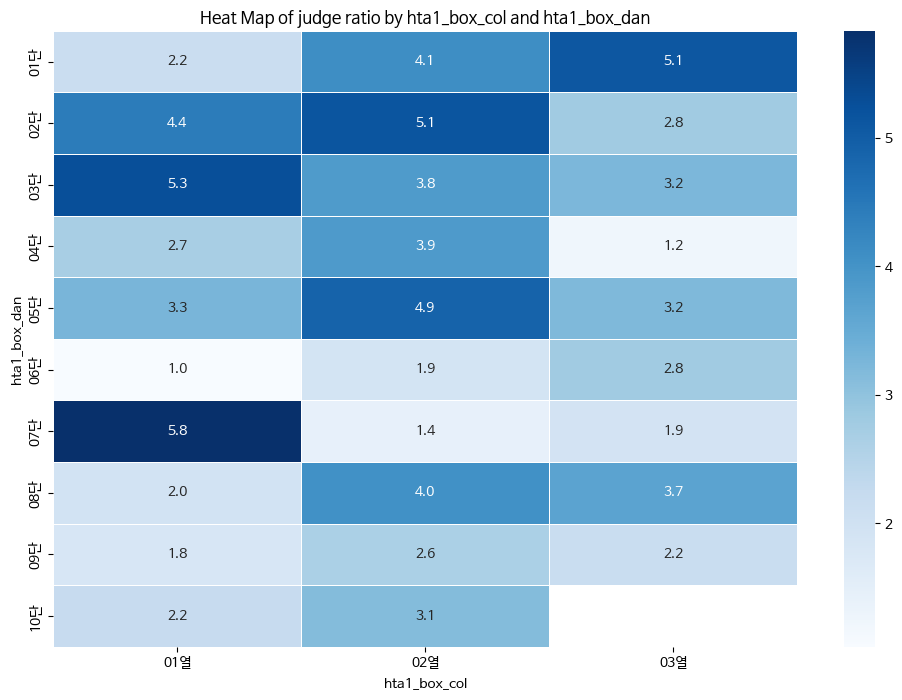

In [59]:
df_raw['hta1_box_col'] = df_raw['hta1_box_col'].astype('category')
df_raw['hta1_box_dan'] = df_raw['hta1_box_dan'].astype('category')

heatmap_data = df_raw.groupby(['hta1_box_col', 'hta1_box_dan'])['ratio'].mean().reset_index()

# 피벗 테이블을 생성하여 데이터를 히트맵에 맞는 형태로 변환합니다.
heatmap_data_pivot = heatmap_data.pivot(index='hta1_box_dan', columns='hta1_box_col', values='ratio')

# 히트맵을 그립니다.
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt=".1f", linewidths=0.5)
plt.title('Heat Map of judge ratio by hta1_box_col and hta1_box_dan')
plt.show()

In [60]:
# judge ratio'의 평균을 계산합니다.
heatmap_data = df_raw.groupby(['hta1_box_col', 'hta1_box_dan'])['ratio'].mean().reset_index()

# 'judge ratio' 열을 기준으로 내림차순 정렬하여 가장 큰 10개의 값을 선택합니다.
top_10_values_2 = heatmap_data.sort_values(by='ratio', ascending=False).head(10)

# 결과를 출력합니다.
print(top_10_values_2)

   hta1_box_col hta1_box_dan     ratio
6           01열          07단  5.833333
2           01열          03단  5.266758
11          02열          02단  5.144695
20          03열          01단  5.108359
14          02열          05단  4.879679
1           01열          02단  4.446013
10          02열          01단  4.094828
17          02열          08단  4.035088
13          02열          04단  3.863038
12          02열          03단  3.830369


### 5-3. 'rta2_box_col', 'rta2_box_dan'(상온 Aging 2의 열과 단)에서의 불량률

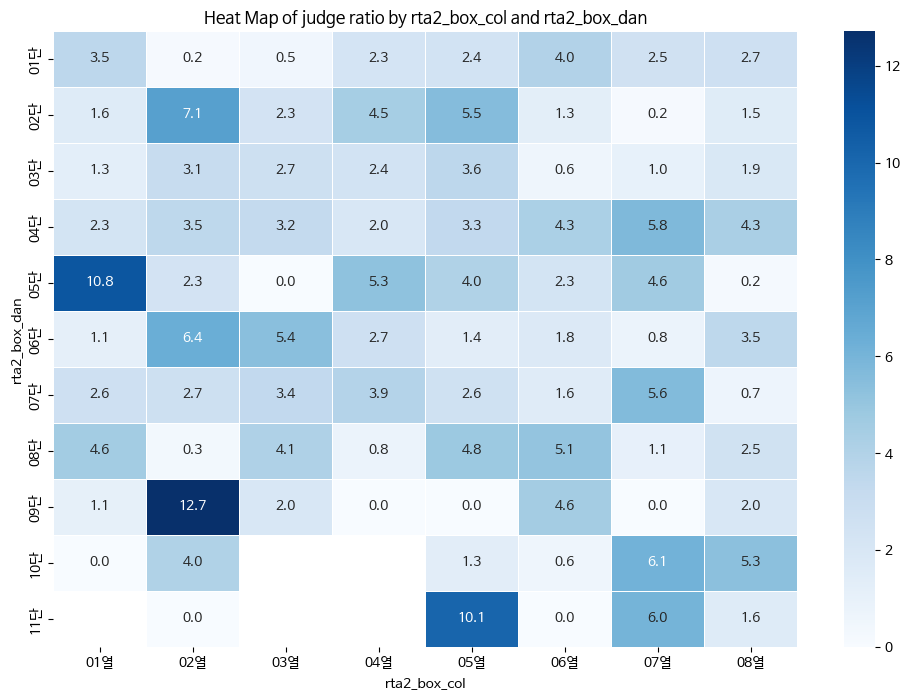

In [72]:
df_raw['rta2_box_col'] = df_raw['rta2_box_col'].astype('category')
df_raw['rta2_box_dan'] = df_raw['rta2_box_dan'].astype('category')

heatmap_data = df_raw.groupby(['rta2_box_col', 'rta2_box_dan'])['ratio'].mean().reset_index()

# 피벗 테이블을 생성하여 데이터를 히트맵에 맞는 형태로 변환합니다.
heatmap_data_pivot = heatmap_data.pivot(index='rta2_box_dan', columns='rta2_box_col', values='ratio')

# 히트맵을 그립니다.
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt=".1f", linewidths=0.5)
plt.title('Heat Map of judge ratio by rta2_box_col and rta2_box_dan')
plt.show()

In [73]:
# judge ratio'의 평균을 계산합니다.
heatmap_data = df_raw.groupby(['rta2_box_col', 'rta2_box_dan'])['ratio'].mean().reset_index()

# 'judge ratio' 열을 기준으로 내림차순 정렬하여 가장 큰 10개의 값을 선택합니다.
top_10_values_3 = heatmap_data.sort_values(by='ratio', ascending=False).head(10)

# 결과를 출력합니다.
print(top_10_values_3)

   rta2_box_col rta2_box_dan      ratio
19          02열          09단  12.722646
4           01열          05단  10.843373
54          05열          11단  10.101010
12          02열          02단   7.142857
16          02열          06단   6.410256
75          07열          10단   6.122449
76          07열          11단   6.036217
69          07열          04단   5.762712
72          07열          07단   5.619597
45          05열          02단   5.518395


### 5-4. 'ocv1_box_col','ocv1_box_dan'에서의 불량률 (9번 반복)
#### 아래의 공정은 공정에서의 열과 단의 위치 같기 때문에, heat map 결과도 같음
'ocv1_box_col', 'ocv1_box_dan','c1_box_col','c1_box_dan','dc1_box_col','dc1_box_dan',
'c2_box_col','c2_box_dan','dc2_box_col','dc2_box_dan','c3_box_col','c3_box_dan',
'dc3_box_col','dc3_box_dan','c4_box_col','c4_box_dan','ocv2_box_col','ocv2_box_dan',

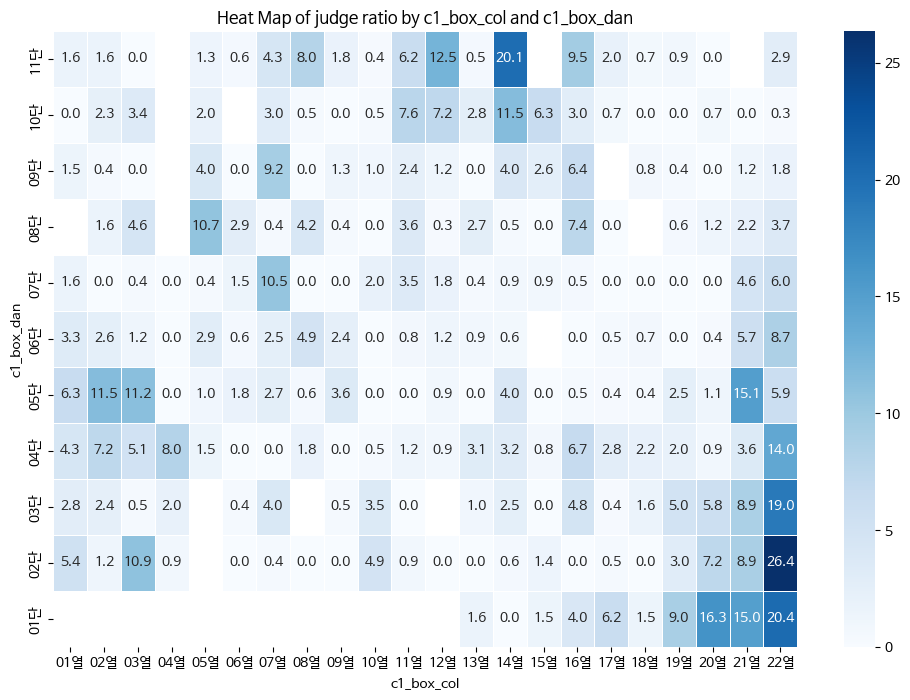

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임을 원하는 순서로 정렬합니다.
dan_order = ['11단', '10단', '09단', '08단', '07단', '06단', '05단', '04단', '03단', '02단', '01단']
col_order = ['01열', '02열', '03열', '04열', '05열', '06열', '07열', '08열', '09열', '10열', '11열',
            '12열', '13열', '14열', '15열', '16열', '17열', '18열', '19열', '20열', '21열', '22열']

df_raw['c1_box_col'] = df_raw['c1_box_col'].astype('category')
df_raw['c1_box_dan'] = df_raw['c1_box_dan'].astype('category')

# 데이터를 원하는 순서로 정렬합니다.
df_raw['c1_box_col'] = pd.Categorical(df_raw['c1_box_col'], categories=col_order, ordered=True)
df_raw['c1_box_dan'] = pd.Categorical(df_raw['c1_box_dan'], categories=dan_order, ordered=True)

heatmap_data = df_raw.groupby(['c1_box_col', 'c1_box_dan'])['ratio'].mean().reset_index()

# 피벗 테이블을 생성하여 데이터를 히트맵에 맞는 형태로 변환합니다.
heatmap_data_pivot = heatmap_data.pivot(index='c1_box_dan', columns='c1_box_col', values='ratio')

# 히트맵을 그립니다.
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt=".1f", linewidths=0.5)
plt.title('Heat Map of judge ratio by c1_box_col and c1_box_dan')
plt.show()

# 6. 설비 별 불량률과 불량 빈도를 비교(Decision Tree) 
#### 공정-불량률 별 우선순위를 얻기 위함

In [68]:
# 필요한 열만 남기고 나머지 열 삭제
columns_to_keep = ['ratio',
                  'rta1_box_col','rta1_box_dan',
                  'hta1_box_col','hta1_box_dan',
                  'rta2_box_col','rta2_box_dan',
                  'c1_box_col','c1_box_dan',]
df = df_raw[columns_to_keep]

# 결과 출력
print(df)

       ratio rta1_box_col rta1_box_dan hta1_box_col hta1_box_dan rta2_box_col  \
0        0.0          08열          08단          03열          03단          04열   
1        0.0          08열          08단          03열          03단          04열   
2        0.0          08열          08단          03열          03단          04열   
3        0.0          08열          08단          03열          03단          04열   
4        0.0          08열          08단          03열          03단          04열   
...      ...          ...          ...          ...          ...          ...   
44073   20.0          08열          03단          02열          06단          03열   
44074   20.0          08열          03단          02열          06단          03열   
44075   20.0          08열          03단          02열          06단          03열   
44076   20.0          08열          03단          02열          06단          03열   
44077   20.0          08열          03단          02열          06단          03열   

      rta2_box_dan c1_box_c

In [69]:
# 'rta1_box_col'과 'rta1_box_dan' 열을 문자열로 변환하여 합치기
df['rta1_combined'] = df['rta1_box_col'].astype(str) + '_' + df['rta1_box_dan'].astype(str)

# 'hta1_box_col'과 'hta1_box_dan' 열을 문자열로 변환하여 합치기
df['hta1_combined'] = df['hta1_box_col'].astype(str) + '_' + df['hta1_box_dan'].astype(str)

# 'rta2_box_col'과 'rta2_box_dan' 열을 문자열로 변환하여 합치기
df['rta2_combined'] = df['rta2_box_col'].astype(str) + '_' + df['rta2_box_dan'].astype(str)

# 'c1_box_col'과 'c1_box_dan' 열을 문자열로 변환하여 합치기
df['c1_combined'] = df['c1_box_col'].astype(str) + '_' + df['c1_box_dan'].astype(str)

# 새로운 DataFrame 확인
print(df[['rta1_combined', 'hta1_combined', 'rta2_combined', 'c1_combined', 'ratio']])

df

      rta1_combined hta1_combined rta2_combined c1_combined  ratio
0           08열_08단       03열_03단       04열_06단     22열_08단    0.0
1           08열_08단       03열_03단       04열_06단     22열_08단    0.0
2           08열_08단       03열_03단       04열_06단     22열_08단    0.0
3           08열_08단       03열_03단       04열_06단     22열_08단    0.0
4           08열_08단       03열_03단       04열_06단     22열_08단    0.0
...             ...           ...           ...         ...    ...
44073       08열_03단       02열_06단       03열_06단     02열_05단   20.0
44074       08열_03단       02열_06단       03열_06단     02열_05단   20.0
44075       08열_03단       02열_06단       03열_06단     02열_05단   20.0
44076       08열_03단       02열_06단       03열_06단     02열_05단   20.0
44077       08열_03단       02열_06단       03열_06단     02열_05단   20.0

[44078 rows x 5 columns]


,ratio,rta1_box_col,rta1_box_dan,hta1_box_col,hta1_box_dan,rta2_box_col,rta2_box_dan,c1_box_col,c1_box_dan,rta1_combined,hta1_combined,rta2_combined,c1_combined
0,0.0,08열,08단,03열,03단,04열,06단,22열,08단,08열_08단,03열_03단,04열_06단,22열_08단
1,0.0,08열,08단,03열,03단,04열,06단,22열,08단,08열_08단,03열_03단,04열_06단,22열_08단
2,0.0,08열,08단,03열,03단,04열,06단,22열,08단,08열_08단,03열_03단,04열_06단,22열_08단
3,0.0,08열,08단,03열,03단,04열,06단,22열,08단,08열_08단,03열_03단,04열_06단,22열_08단
4,0.0,08열,08단,03열,03단,04열,06단,22열,08단,08열_08단,03열_03단,04열_06단,22열_08단
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44073,20.0,08열,03단,02열,06단,03열,06단,02열,05단,08열_03단,02열_06단,03열_06단,02열_05단
44074,20.0,08열,03단,02열,06단,03열,06단,02열,05단,08열_03단,02열_06단,03열_06단,02열_05단
44075,20.0,08열,03단,02열,06단,03열,06단,02열,05단,08열_03단,02열_06단,03열_06단,02열_05단
44076,20.0,08열,03단,02열,06단,03열,06단,02열,05단,08열_03단,02열_06단,03열_06단,02열_05단


In [70]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# LabelEncoder를 사용한 간단한 예시
label_encoder = LabelEncoder()

# 각 열을 레이블 인코딩
df['rta1_encoded'] = label_encoder.fit_transform(df['rta1_combined'])
df['hta1_encoded'] = label_encoder.fit_transform(df['hta1_combined'])
df['rta2_encoded'] = label_encoder.fit_transform(df['rta2_combined'])
df['c1_encoded'] = label_encoder.fit_transform(df['c1_combined'])

# Features와 Target 재설정
X = df[['rta1_encoded', 'hta1_encoded', 'rta2_encoded', 'c1_encoded']]
y = df['ratio']

# 결정 트리 모델 생성 및 학습
dt = DecisionTreeRegressor(random_state=1234, min_samples_leaf=3, min_samples_split=2)
dt.fit(X, y)

# 특성 중요도 확인
feature_importances = dt.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도에 따라 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 중요도 출력
print(feature_importance_df)

        Feature  Importance
3    c1_encoded    0.359232
0  rta1_encoded    0.263008
1  hta1_encoded    0.216877
2  rta2_encoded    0.160884


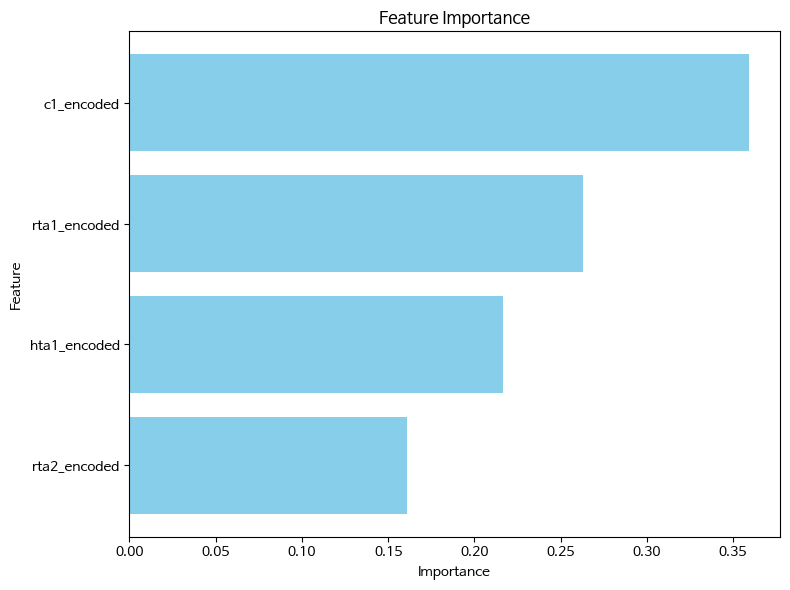

In [71]:
import matplotlib.pyplot as plt

# 중요도에 따라 내림차순 정렬된 데이터프레임을 사용하여 막대 그래프 그리기
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # y축 역순으로 정렬하여 상위 특성이 위에 오도록 설정
plt.tight_layout()
plt.show()


# 7. 결과

### 불량 발생 빈도에 대한 검정 결과(카이제곱)
- 설비 내 tray 위치에 따라 불량 발생 빈도에 차이가 있음

### 불량률에 대한 검정 결과(아노바)
- 설비 내 tray 위치에 따라 불량률에 차이가 있화

### 설비 별 불량률과 불량 빈도를 비교(의사결정나무)
- 충전/방전 → 상온 Aging1 → 고온 Aging1 → 상온 Aging2

### 설비 유의차와 불량률간의 관계 시각화(히트맵)
- 설비의 가장자리에서 불량률이 높이 나타남